In [3]:
!rm -rf Eunomia
!git clone https://github.com/ouaguenouni/Eunomia
!pip install -r Eunomia/requirements.txt

Cloning into 'Eunomia'...
remote: Enumerating objects: 2784, done.
remote: Counting objects: 100% (2784/2784), done.
remote: Compressing objects: 100% (522/522), done.
remote: Total 2784 (delta 2338), reused 2696 (delta 2250), pack-reused 0
Receiving objects: 100% (2784/2784), 11.32 MiB | 3.41 MiB/s, done.
Resolving deltas: 100% (2338/2338), done.


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from Eunomia.preferences import *
from Eunomia.additive_functions import *
from Eunomia.alternatives import *
from Eunomia.sampling import *
from Eunomia.mcmc import *
#from Eunomia.degree import *
from Eunomia.experiments import *
from Eunomia.ssb import * 
from Eunomia.graph_utils import * 
from docplex.mp.model import Model
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm, trange
import networkx as nx
import matplotlib.pyplot as plt
pyro.set_rng_seed(1)

In [5]:
def remove_bidir_arcs(graph):
    graph2 = nx.DiGraph()
    for x,y in graph.edges():
        if not (y,x) in graph2.edges():
            graph2.add_edge(x,y)
    return graph2


def sample_random_graph(n, degree, method = "gnp", **kwargs):
    subsets = [tuple(i) for i in generate_additive_theta(n, degree)]
    methods = ["gnp"]
    if method not in methods:
        print("Unknown method")
        return None
    if method == "gnp":
        if not "p" in kwargs:
            print("missing param p")
            return None
        random_graph = nx.fast_gnp_random_graph(len(subsets), kwargs["p"], directed = True)
        random_graph = remove_bidir_arcs(random_graph)
        random_graph = nx.relabel_nodes(random_graph, {i: label for i, label in enumerate(subsets)})
    return random_graph

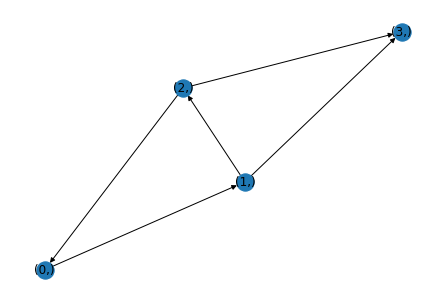

In [6]:
graph = sample_random_graph(4,1,p=0.6)
nx.draw(graph, with_labels=True, arrows=True)
plt.show()

In [7]:
def get_all_pairs(L):
    pairs = []
    for i in range(len(L)):
        for j in range(i+1, len(L)):
            pairs.append((L[i], L[j]))
    return pairs

In [13]:
class SSB_Model:
    def __init__(self, items, theta = None, phi=None, degree = 1):
        self.items = items
        if not theta and not phi:
            theta = [tuple(i) for i in generate_additive_theta(len(items), degree)]
            phi = get_all_pairs(theta)
        self.theta = theta
        self.phi = phi
        self.solved = False
        
        self.r_theta = 0
        self.r_phi = 0
        self.eps = []
        
        self.mdl = Model(name='SSB_Model')

        self.w_vars = {}
        for k in self.theta:
            self.w_vars[k] = self.mdl.continuous_var(name="w_"+str(set(k)),lb =-np.infty, ub = np.infty)
            self.r_theta =  self.r_theta + self.mdl.abs(self.w_vars[k])
             
        self.b_vars = {}      
        for k in self.phi:
            self.b_vars[k] = self.mdl.continuous_var(name="b_("+str(set(k[0]))+"->"+str(set(k[1]))+")",lb =-np.infty,ub = np.infty)
            self.r_phi =  self.r_phi + self.mdl.abs(self.b_vars[k])

    
    def project(self, x, y):
        s = 0
        for k in self.theta:
            if all(i in x for i in k):
                s += self.w_vars[k]
            if all(i in y for i in k):
                s -= self.w_vars[k]
                
        for A,B in self.phi:
            if all(i in x for i in A) and all(i in y for i in B):
                s += self.b_vars[(A,B)]
            if all(i in x for i in B) and all(i in y for i in A):
                s -= self.b_vars[(A,B)]
        return s
    
    def fit(self, prf):
        self.prf = prf
        edges = []
        self.eps = []
        for x,y in self.prf:
            if (set(y),set(x)) in edges:
                continue
            edges.append((set(x),set(y)))
            eps = self.mdl.continuous_var(name=f"eps_({set(x)}_{set(y)})",lb =0,ub = np.infty)
            cst = self.mdl.add_constraint(self.project(x,y) >= 1 - eps, ctname = f"c_({set(x)}_{set(y)})")
            self.eps.append(eps)
        self.mdl.minimize_static_lex([self.mdl.sum(self.eps), self.r_theta + 100*self.r_phi])
        s = self.mdl.solve(log_output = False)
        if s:
            self.solved = True
        return s
    
    def predict(self, x,y):
        if not self.solved:
            print("PL not solved")
            return None
        s = 0
        for k in self.theta:
            if all(i in x for i in k):
                s += self.w_vars[k].solution_value
            if all(i in y for i in k):
                s -= self.w_vars[k].solution_value
                
        for A,B in self.phi:
            if all(i in x for i in A) and all(i in y for i in B):
                s += self.b_vars[(A,B)].solution_value
            if all(i in x for i in B) and all(i in y for i in A):
                s -= self.b_vars[(A,B)].solution_value
        return s
    
    def get_ssb_function(self):
        model = {}
        model["w"] = {}
        model["b"] = {}
        for s in self.w_vars:
            model["w"][s] = self.w_vars[s].solution_value
        for b in self.b_vars:
            model["b"][b] = self.b_vars[b].solution_value
        return model
    
    def n_ssb_vars(self):
        return sum([1 if np.abs(self.b_vars[i].solution_value) > 0 else 0 for i in self.b_vars])

    def n_w_vars(self):
        return sum([1 if np.abs(self.w_vars[i].solution_value) > 0 else 0 for i in self.w_vars])
    
    def ratio_of_representation(self):
        return 1 - sum([1 if i.solution_value > 0 else 0 for i in self.eps]) / len(self.eps)
    
    def print_model(self):
        print("% representation =", self.ratio_of_representation())
        for x in self.w_vars:
            if (self.w_vars[x].solution_value != 0):
                print(f"w_{x}: {self.w_vars[x].solution_value}")
        
        for x,y in self.b_vars:
            if self.b_vars[(x,y)].solution_value != 0:
                print(f"b_({x}->{y}): {self.b_vars[(x,y)].solution_value}")
            

In [161]:
n = 3
items = np.arange(n)

In [162]:
graph = sample_random_graph(n, 2, p=0.3)
prf = list(graph.edges())

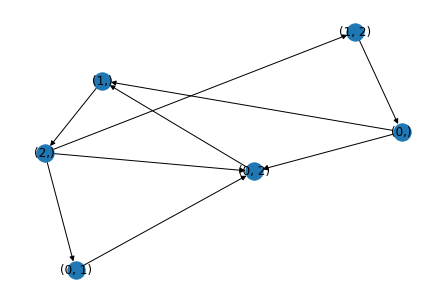

In [163]:
nx.draw(graph, with_labels=True, arrows=True)
plt.show()

In [166]:
model = SSB_Model(items, degree = 2)
model.fit(prf)

docplex.mp.solution.SolveSolution(obj=0,values={w_{0}:1,_abs1:1,x3:1,w_{..

In [167]:
ssb_f = model.get_ssb_function()
ssb_f

{'w': {(0,): 1.0, (1,): 0, (2,): -1.0, (0, 1): 0, (0, 2): 1.0, (1, 2): 0},
 'b': {((0,), (1,)): 0,
  ((0,), (2,)): -3.0,
  ((0,), (0, 1)): 0,
  ((0,), (0, 2)): 4.0,
  ((0,), (1, 2)): 0,
  ((1,), (2,)): 0,
  ((1,), (0, 1)): 0,
  ((1,), (0, 2)): 0,
  ((1,), (1, 2)): 0,
  ((2,), (0, 1)): 0,
  ((2,), (0, 2)): 0,
  ((2,), (1, 2)): 1.0,
  ((0, 1), (0, 2)): 0,
  ((0, 1), (1, 2)): 0,
  ((0, 2), (1, 2)): 0}}

In [178]:
mdl = Model(name='SSB_Solver')
S = (0,1)
mdl.w = {}
obj = 0
mdl.vars = {i: mdl.binary_var(name = f"y_{i}") for i in items}

for x in ssb_f["w"]:
    mdl.w[x] = mdl.binary_var(name = f"y_{set(x)}")
    c= mdl.add_constraint(mdl.w[x] == mdl.logical_and(*[mdl.vars[i] for i in x]))
    obj += (mdl.w[x] - int(all(i in S for i in x))) * ssb_f["w"][x]

for x in ssb_f["b"]:
    A = x[0]
    B = x[1]
    coeff = ssb_f["b"][x]
    obj += (mdl.w[A] * int(all(i in S for i in B)))*coeff 
    obj -= (mdl.w[B] * int(all(i in S for i in A)))*coeff 

mdl.maximize(obj)
mdl.solve()

docplex.mp.solution.SolveSolution(obj=1,values={y_2:1,y_{2}:1})

In [179]:
for x in mdl.vars:
    print(f"{x}:{mdl.vars[x].solution_value}")

0:0
1:0
2:1.0


In [115]:
prf

[((0,), (1,)), ((1,), (2,)), ((2,), (0,)), ((2,), (3,)), ((3,), (0,))]